# Lab: California Housing Prediction with SageMaker

#### **Problem Statement**

Real estate pricing depends on many interacting factors such as income levels, population density, housing characteristics, and geographic location.  
In this lab, you will build an **end-to-end machine learning pipeline** to predict **median house values in California** using census-style data and Amazon SageMaker.

The goal of this lab is to predict the **median house value** for California districts based on 1990 census data. This is a classic regression task where we must account for economic factors (income), demographics (population), and geography (location).

The overall goal is not just to train a model, but to understand how **managed ML workflows** differ from local experimentation.


#### **Lab Objectives**

* **Master the SageMaker SDK:** Learn to interact with AWS services directly from a Jupyter notebook.
* **Managed Training:** Execute a training job on a remote, managed cluster using the AWS **Linear Learner** algorithm.
* **Real-time Inference:** Deploy a trained model to a persistent HTTP endpoint.
* **Model Benchmarking:** Compare the performance of a cloud-native model against a local Scikit-Learn implementation.

#### **Learning Goals**

By completing this lab, you will learn how to:

- Explore and visualize a real-world regression dataset
- Prepare and transform features for machine learning
- Upload training data to Amazon S3
- Train a regression model using **SageMaker Linear Learner**
- Deploy a trained model as a **real-time inference endpoint**
- Invoke the endpoint for predictions
- Benchmark SageMaker results against a local scikit-learn model
- Clean up deployed resources to avoid ongoing costs
---

#### **High-Level Tasks**

1. **Environment Setup:** Initialize SageMaker sessions and S3 buckets.
2. **Exploratory Data Analysis (EDA):** Visualize geospatial trends and feature correlations.
3. **Feature Engineering:** Clean, scale, and transform raw data into "SageMaker-ready" CSV formats.
4. **Model Training:** Configure and launch a managed training job.
5. **Deployment:** Host the model as an API endpoint.
6. **Inference & Evaluation:** Test the endpoint with unseen data and calculate error metrics (RMSE).
7. **Resource Cleanup:** Terminate active endpoints to manage costs.

---

## 1. Environment Setup

In SageMaker JupyterLab, the environment is pre-configured with the AWS SDK (`boto3`) and the high-level `sagemaker` library. We initialize our session and define where our data will live in S3.

In [1]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize SageMaker Session
session = sagemaker.Session()
region = session.boto_region_name

# 2. Get Execution Role (The permissions this notebook has)
# In SageMaker Studio/JupyterLab, this automatically grabs the role attached to your user profile.
role = sagemaker.get_execution_role()

# 3. Define S3 Bucket and Prefix
# We use the default bucket created by SageMaker for you.
bucket = session.default_bucket()
prefix = 'labs/california-housing'

print(f"Region: {region}")
print(f"S3 Bucket: {bucket}")
print(f"IAM Role: {role.split('/')[-1]}") # Printing just the role name for readability

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-west-2
S3 Bucket: sagemaker-us-west-2-962804699607
IAM Role: AmazonSageMaker-ExecutionRole-20260113T173502


---

## 2. Data Ingestion & Exploration (EDA)

We will use `sklearn` to fetch the classic 1990 California Housing dataset.

In [2]:
df = pd.read_csv("data/california_housing_prices/california_housing_prices.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### 2.1 Visualizing the Geography

Since this is geospatial data, plotting the longitude and latitude reveals the map of California.

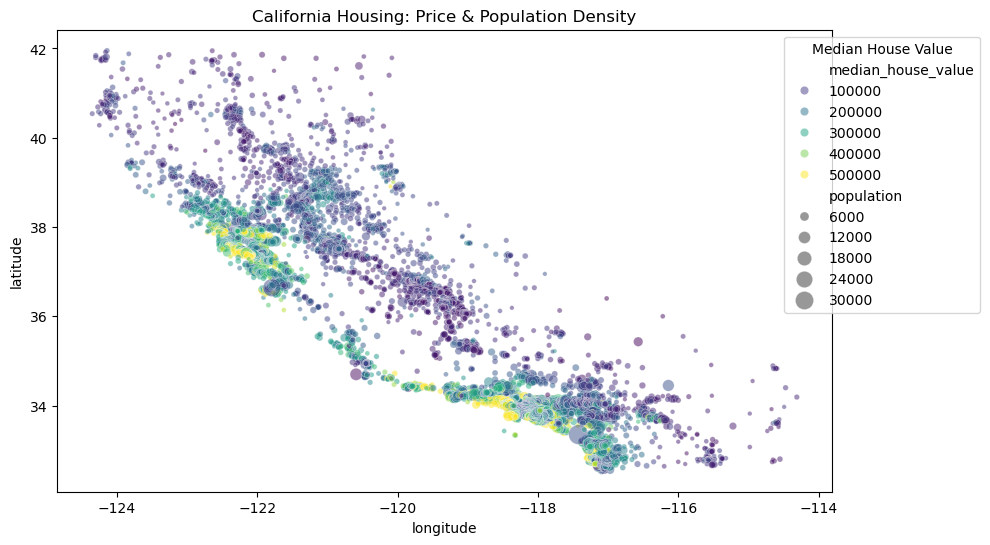

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    size="population",
    hue="median_house_value",
    palette="viridis",
    alpha=0.5,
    sizes=(10, 200) # Control the size of the dots
)
plt.title("California Housing: Price & Population Density")
plt.legend(title="Median House Value", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()

### 2.2 Correlation Analysis

We need to see which features drive housing prices.

* **Note:** `MedInc` (Median Income) usually has the strongest correlation with `MedHouseVal`.

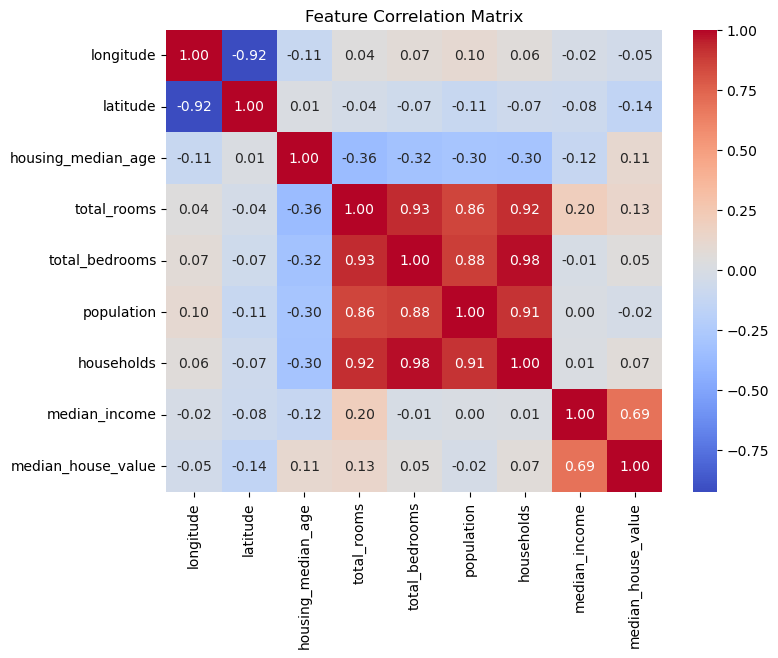

In [5]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

---

## 3. Data Wrangling & Feature Engineering

SageMaker's Linear Learner expects specific data formats. We will perform the following processing:

1. **Feature Engineering:** Create `RoomsPerHousehold` to normalize the room count.
2. **Imputation:** (The sklearn version of this dataset is pre-cleaned, but in real scenarios, you would handle `NaNs` here).
3. **Splitting:** 70% Train, 15% Validation, 15% Test.
4. **Scaling:** Standardize data (Mean , Variance ).

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Feature Engineering
# Using the raw census columns to create ratios
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# 2. Prepare X (Features) and y (Target)
# We drop the target AND the categorical 'ocean_proximity' for the baseline linear model
X = df.drop(["median_house_value", "ocean_proximity"], axis=1)
y = df["median_house_value"]

# Handle missing values (total_bedrooms often has NaNs in this dataset)
X = X.fillna(X.median())

# 3. Train / Validation / Test Split
# First split: Train (70%) vs Temp (30%)
X_train_raw, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: Temp into Validation (15%) and Test (15%)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 4. Standardization (Scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print(f"Training Data:   {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Test Data:       {X_test.shape}")

Training Data:   (14448, 11)
Validation Data: (3096, 11)
Test Data:       (3096, 11)


### 3.1 Uploading Data to S3

When training with SageMaker, the compute instance (the "training job") spins up in the background and needs to download data from S3.

**Format Requirement:** For CSV input to Linear Learner, the **first column must be the target variable**, and there should be no headers.

In [7]:
import io

def upload_to_s3(X, y, channel_name):
    # Stack target (y) as the first column, followed by features (X)
    data = np.column_stack((y, X))

    # Write to a CSV buffer (in-memory)
    csv_buffer = io.BytesIO()
    np.savetxt(csv_buffer, data, delimiter=',', fmt='%g')

    # Construct S3 Key
    s3_key = f"{prefix}/{channel_name}/data.csv"

    # Upload
    boto3.resource('s3').Bucket(bucket).put_object(Key=s3_key, Body=csv_buffer.getvalue())
    s3_uri = f"s3://{bucket}/{s3_key}"
    print(f"Uploaded {channel_name} data to: {s3_uri}")
    return s3_uri

# Upload Train and Validation sets
s3_train_uri = upload_to_s3(X_train, y_train, 'train')
s3_val_uri = upload_to_s3(X_val, y_val, 'validation')

Uploaded train data to: s3://sagemaker-us-west-2-962804699607/labs/california-housing/train/data.csv
Uploaded validation data to: s3://sagemaker-us-west-2-962804699607/labs/california-housing/validation/data.csv


---

## 4. Training: AWS Linear Learner

We will now launch a **Training Job**. This happens on a separate EC2 instance managed by SageMaker, not in this notebook.

### 4.1 Define the Estimator

We use the `sagemaker.image_uris` to get the Docker container for the Linear Learner algorithm.

In [8]:
from sagemaker.image_uris import retrieve

# 1. Retrieve the container image
container = retrieve('linear-learner', region)

# 2. Define the Estimator (The configuration for the training job)
ll_estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large', # Balanced general purpose instance
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=session
)

# 3. Set Hyperparameters
ll_estimator.set_hyperparameters(
    feature_dim=X_train.shape[1], # Must match number of columns in X
    predictor_type='regressor',   # Regression problem
    mini_batch_size=100,
    epochs=15,
    normalize_data=False,         # We already scaled it
    loss='squared_loss'           # Optimizing for MSE
)

### 4.2 Execute Training

This block will output logs from the remote instance. Wait for it to complete (approx 3-4 minutes).

In [9]:
# Define the data channels
train_input = sagemaker.inputs.TrainingInput(s3_train_uri, content_type='text/csv')
val_input = sagemaker.inputs.TrainingInput(s3_val_uri, content_type='text/csv')

# Start the job
#ll_estimator.fit({'train': train_input, 'validation': val_input})


# Start the job without streaming the verbose logs
ll_estimator.fit({'train': train_input, 'validation': val_input}, logs=False)

print("Training job completed successfully!")

INFO:sagemaker:Creating training-job with name: linear-learner-2026-01-17-20-45-31-738



2026-01-17 20:45:32 Starting - Starting the training job.
2026-01-17 20:45:47 Starting - Preparing the instances for training....
2026-01-17 20:46:10 Downloading - Downloading input data........
2026-01-17 20:46:55 Downloading - Downloading the training image...............
2026-01-17 20:48:16 Training - Training image download completed. Training in progress.........
2026-01-17 20:49:01 Uploading - Uploading generated training model...
2026-01-17 20:49:19 Completed - Training job completed
Training job completed successfully!


---

## 5. Deployment & Inference

Once training is successful, we deploy the model to an **Endpoint**. This creates a persistent REST API that we can query.

In [10]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Deploy (approx 3-5 mins)
predictor = ll_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium', # Cost-effective for lab inference
    serializer=CSVSerializer(),   # Converts list -> CSV for the endpoint
    deserializer=JSONDeserializer() # Parses JSON response from endpoint
)

print(f"Endpoint deployed: {predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: linear-learner-2026-01-17-20-49-24-288
INFO:sagemaker:Creating endpoint-config with name linear-learner-2026-01-17-20-49-24-288
INFO:sagemaker:Creating endpoint with name linear-learner-2026-01-17-20-49-24-288


---------------!Endpoint deployed: linear-learner-2026-01-17-20-49-24-288


### 5.1 Testing the Prediction

Let's send a single record from our test set to the endpoint to see the result.

In [11]:
# Take one sample
sample_input = X_test[0]
actual_value = y_test.iloc[0]

# Query the endpoint
response = predictor.predict(sample_input)

# Extract prediction
predicted_value = response['predictions'][0]['score']

print(f"Actual Value:    ${actual_value * 100000:,.2f}")
print(f"Predicted Value: ${predicted_value * 100000:,.2f}")

Actual Value:    $10,000,000,000.00
Predicted Value: $12,967,517,968.75


---

## 6. Benchmarking: SageMaker vs. Scikit-Learn

To understand if our model is "good," we compare it to a reference implementation running locally in the notebook.

### 6.1 Scikit-Learn Reference (Local)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Local Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict Local
y_pred_sklearn = lr.predict(X_test)

# Calculate RMSE
rmse_sklearn = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
print(f"Scikit-Learn RMSE: {rmse_sklearn:.4f}")

Scikit-Learn RMSE: 66851.0051


### 6.2 SageMaker Evaluation (Remote)

We batch predict the entire test set using the endpoint.

In [13]:
def predict_batch(data, predictor, rows=500):
    # Split data into chunks to respect payload limits
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        result = predictor.predict(array)
        predictions += [r['score'] for r in result['predictions']]
    return np.array(predictions)

# Get all predictions
y_pred_aws = predict_batch(X_test, predictor)

# Calculate RMSE
rmse_aws = np.sqrt(mean_squared_error(y_test, y_pred_aws))

print("------ RESULTS ------")
print(f"AWS Linear Learner RMSE: {rmse_aws:.4f}")
print(f"Scikit-Learn RMSE:       {rmse_sklearn:.4f}")
print("---------------------")

------ RESULTS ------
AWS Linear Learner RMSE: 67094.9283
Scikit-Learn RMSE:       66851.0051
---------------------


*Note: The results should be very similar as both use linear regression techniques. Slight differences arise from optimization solvers (SGD vs OLS) and regularization defaults.*

---

## 7. Cleanup

**⚠️ IMPORTANT:** Delete the endpoint to stop billing.

In [14]:

# Optional: Delete the model and endpoint configuration if you want a clean slate
predictor.delete_model()

# Delete endpoint
predictor.delete_endpoint()

print("Endpoint deleted. Lab complete.")

INFO:sagemaker:Deleting model with name: linear-learner-2026-01-17-20-49-24-288
INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2026-01-17-20-49-24-288
INFO:sagemaker:Deleting endpoint with name: linear-learner-2026-01-17-20-49-24-288


Endpoint deleted. Lab complete.


**=========== the lab ends here ============**

---

## Optional: No-Code Extension (SageMaker Canvas)


**SageMaker Canvas** is a "no-code" machine learning interface that allows you to build the same regression model (predicting housing prices) without writing a single line of Python. It uses the same AutoML technology (Amazon SageMaker Autopilot) under the hood.


**Role:** Business Analyst / Citizen Data Scientist
**Tool:** Amazon SageMaker Canvas
**Objective:** Build a regression model to predict `MedHouseVal` using a visual drag-and-drop interface.

---

## 1. Preparation

Before starting, ensure you have the dataset file on your local computer.

* **Download:** If you don't have it, you can download the `housing.csv` from the [standard repository](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv) or export it from your previous notebook using `df.to_csv('housing.csv', index=False)`.

## 2. Launch SageMaker Canvas

1. Open the **AWS Console** and navigate to **Amazon SageMaker**.
2. In the left sidebar, select **Canvas**.
3. Select your User Profile and click **Open Canvas**. (This may take 1-2 minutes to initialize).

---

## 3. Step-by-Step Walkthrough

### Step 1: Import Data

We need to load the California Housing CSV into Canvas.

1. On the left sidebar, click the **Datasets** icon (database symbol).
2. Click **Import** (top right).
3. Choose **Upload** (from your computer) and select your `housing.csv` file.
4. Click **Preview** to verify the columns (`Longitude`, `Latitude`, `MedHouseVal`, etc.) look correct.
5. Click **Import Data**.

### Step 2: Build the Model

Now we define what we want to predict.

1. Go to the **My models** tab (model symbol) on the left sidebar.
2. Click **New model** and name it `CaliforniaHousing-Regression`.
3. Select the **Predictive Analysis** radio button and click **Create**.
4. **Select Dataset:** Choose the `housing.csv` you just imported and click **Select dataset**.

### Step 3: Configure Target & Model Type

1. **Select Target Column:** In the "Target column" dropdown, select **`MedHouseVal`** (Median House Value).
2. **Verify Model Type:** Canvas will automatically detect this is a **Numeric Prediction** (Regression) problem.
3. **Data Preview:** You will see a distribution histogram of house prices.
4. **Build Options:** You have two choices:
* **Quick Build:** Takes 2-15 minutes. Good for rapid prototyping. (Recommended for this lab).
* **Standard Build:** Takes 1-2 hours. detailed analysis and higher accuracy.


5. Click **Quick Build**.

### Step 4: Analyze Results

Once the build is complete (approx. 10 mins), Canvas presents a visual dashboard.

1. **Overview Tab:** Look at the **RMSE** (Root Mean Squared Error).
* *Compare this number to the Python notebook result. It usually achieves similar performance.*


2. **Column Impact:** This is the equivalent of "Feature Importance."
* You will likely see **`MedInc`** (Median Income) having the highest percentage impact, consistent with our Python analysis.
* You can click on a column (e.g., `Latitude`) to see how changing its value impacts the predicted price (Partial Dependence Plots).



### Step 5: Generate Predictions

1. Click the **Predict** button at the bottom of the analysis page.
2. **Single Prediction (What-if analysis):**
* Manually adjust sliders for `MedInc` or `AveRooms` to see how the predicted House Value changes in real-time.


3. **Batch Prediction:**
* If you have a separate test file (without targets), you can upload it here. Canvas will generate a CSV with predictions for every row.



---
Video tutorial:
[Build a Regression Model in 11 minutes with Amazon Sagemaker Canvas](https://www.youtube.com/watch?v=o_vPaVQ8D1o)
